# Analyzing Cain's Jawbone with Word Vectoring and K-Means Clustering

## Cain’s Jawbone

[We suggested a solution to Cain’s Jawbone as a personal project almost a year ago.](https://glthr.com/cj)

Cain’s Jawbone, by Edward Powys Mathers, is a puzzle consisting of 100 shuffled pages. To manually solve it, the following heuristic was used:

* Group the pages by narrators (there are eight of them, concealed in the narration).
* Then, sort the pages in each group.
* Last but not least, sort the groups themselves.

Now, we would like to investigate whether artificial intelligence (in a broad sense) could be used to find a solution more efficiently, at least partially. We are only at the very beginning of this analysis.

First, let's load *Cain’s Jawbone* as a DataFrame.

In [1]:
import pandas as pd

df_cain = pd.read_json("./data/jawbone.json")

# ensure that the input file is complete
if len(df_cain[df_cain["text"].notna() & (df_cain["text"] != "")]) != 100:
    print("Error: the original corpus is incomplete")
    exit

df_cain.head()

,page,text
0,1,I sit down alone at the appointed table and ta...
1,2,I plunged for the last time. The few remaining...
2,3,"At my meeting with Clement yesterday, he had b..."
3,4,And I really think I would have preferred the ...
4,5,I hated my eye for being caught by what didn’t...


_(Reserved for later use)_ Then, an unofficial solution from our previous manual attempt shared at [https://glthr.com/cj/](glthr.com/cj/) is loaded. It will only adjust the models as the training is unsupervised.

In [2]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()

possible_solutions

{'Oscar Mills': [92, 42, 2, 38, 90, 62, 53, 14, 66, 74, 83, 31],
 'May Doncaster': [72, 49, 13, 26, 44, 94, 16, 68, 58, 5, 81, 77, 35],
 'Sir Paul Trinder': [28, 9, 52, 12, 50, 65, 18, 34, 76, 89, 78, 98],
 'Clement DeAth': [54, 80, 91, 71, 59, 86, 24, 6, 21, 36, 29, 75, 60],
 'Bill Hardy': [1, 96, 17, 23, 87, 43, 84, 63, 47, 4, 30, 100],
 'Jasmine Gay': [69, 56, 27, 37, 7, 45, 82, 41, 93, 11, 15, 95, 70],
 'John Walker': [32, 3, 25, 73, 67, 51, 55, 61, 20, 40, 97, 85],
 'Henry (dog)': [64, 22, 79, 48, 88, 39, 46, 10, 99, 8, 19, 57, 33]}

## Naive Clustering

To begin our analysis of the suitability of artificial intelligence, we perform a classic unsupervised learning approach (word vectorization and k-means clustering) to group the pages automatically. At this stage of the analysis, we explicitly set `k` to the expected number of groups (8). 

### TF-IDF word vectorization.

In [3]:
import warnings

warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

tokenized_sentences = [word_tokenize(sentence) for sentence in df_cain["text"]]

# words vectorization (TF-IDF)
vectorizer = TfidfVectorizer(analyzer="word")
X = vectorizer.fit_transform([" ".join(tokens) for tokens in tokenized_sentences])

print(f"{X.shape} vectors")

(100, 3786) vectors


### K-means clustering performed with the *known* number of clusters.

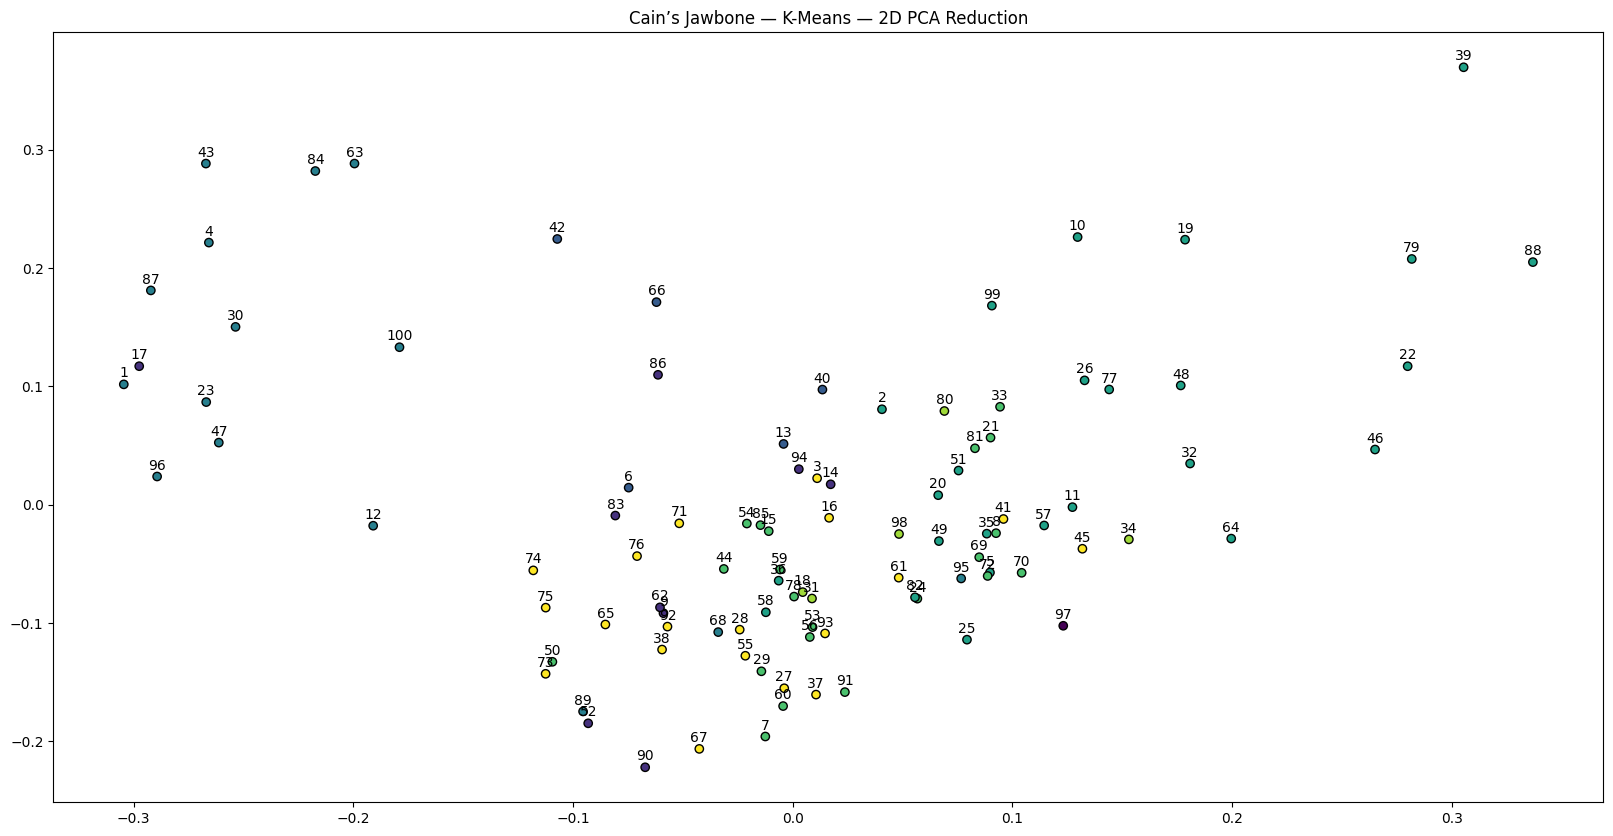

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# the number of clusters is defined from the unofficial solution
k = 8

kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(X)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

df_cain["cluster"] = labels

# dimensionality reduction (2 dimensions)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# plot
plt.figure(figsize=(20, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="viridis", edgecolor="k")
for i, txt in enumerate(df_cain["page"]):
    plt.annotate(
        txt,
        (X_pca[i, 0], X_pca[i, 1]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )

plt.title("Cain’s Jawbone — K-Means — 2D PCA Reduction")
plt.show()

## Preliminary Analysis

We anticipated that the result would be limited because of (a) the extratextual clues, (b) the simplicity of our approach—at this stage, at least—, and (c) the fact that the pages were all written by the same person pretending to be eight different narrators (meaning that the style difference between the pages is artificial, not intrinsic). 

While the clusters do not greatly overlap the expected groups (even though k is set to the actual number of narrators), the representation of the PCA reduction of naive k-means clustering revealed an “affinity” (which remains to be formalized) between some of the pages which is more or less in line with the expected solution. This is particularly true for Bill Hardy and Henry the dog.

![Clusters](./clusters.png)

These preliminary results tend to indicate that NLP may be suitable, to some extent, to identify the narrators. To that end, it will need to be improved to use additional clues and automatically determine the number of narrators (we tried to use the elbow method to that end, but as it was inconclusive in the context of this preliminary analysis, and therefore had to specify this number ourselves).